# Krylov Confusion Matrix
---

This notebook generates and visualizes the krylov loss for the opening angle as a confusion matrix.

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [1]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
import xarray as xr
import scipy as sci
import time

In [2]:
def objective_fun(x, solver, measurements, degree, n_jobs=4):
    solver.update_diffusion(pynoisy.diffusion.general_xy(solver.nx, solver.ny, opening_angle=x))
    error = krylov_error_fn(solver, measurements, degree, n_jobs)
    loss = (error**2).mean()
    return np.array(loss)

def krylov_error_fn(solver, measurements, degree, n_jobs=4):
    krylov = solver.run(source=measurements, nrecur=degree, verbose=0, std_scaling=False, n_jobs=n_jobs)
    k_matrix = krylov.data.reshape(degree, -1)
    result = np.linalg.lstsq(k_matrix.T, np.array(measurements).ravel(), rcond=-1)
    coefs, residual = result[0], result[1]
    random_field = np.dot(coefs.T, k_matrix).reshape(*measurements.shape)
    error = random_field - measurements
    return error

In [4]:
nt, nx, ny = 64, 64, 64
krylov_degree = 8
spatial_res = 50
n_jobs = 4

advection_true = pynoisy.advection.general_xy(nx, ny)
diffusion_true = pynoisy.diffusion.general_xy(nx, ny)
solver = pynoisy.forward.HGRFSolver(nx, ny, advection_true, diffusion_true)
spatial_grid = np.linspace(-np.pi/2, np.pi/2, spatial_res)
loss = np.empty((spatial_res, spatial_res))

for i, true_angle in enumerate(tqdm(spatial_grid, desc='true angle')):
    # Generate ground truth grf
    solver.update_diffusion(pynoisy.diffusion.general_xy(nx, ny, opening_angle=true_angle))
    grf_true = solver.run(num_frames=nt, n_jobs=n_jobs)
    
    # Generate grf-like measurements 
    measurements_grf = grf_true.copy()
    for j, angle in enumerate(tqdm(spatial_grid, desc='estimated angle', leave=False)):
        loss[i, j] = objective_fun(angle, solver, measurements_grf, degree=krylov_degree, n_jobs=n_jobs)

# Create a dataset and save it
dataset = xr.Dataset(
    data_vars={'loss': (['true_angle', 'estimated_angle'], loss)},
    coords={'true_angle': spatial_grid, 'estimated_angle':spatial_grid},
    attrs={'date': time.strftime("%d-%b-%Y-%H:%M:%S"),
           'desc': 'diffusion opening angle confusion matrix for ground-truth ' + 
                   'grf measurements with no std_scaling.',
            'seed': grf_true.seed, 'nx': nx, 'ny': ny, 'nt': nt, 'krylov_degree': krylov_degree
          })
dataset.to_netcdf('confusion_matrix_diffusion_opening_angle_seed{}_degree{}.nc'.format(
    dataset.seed, dataset.krylov_degree))

<IPython.core.display.Javascript object>


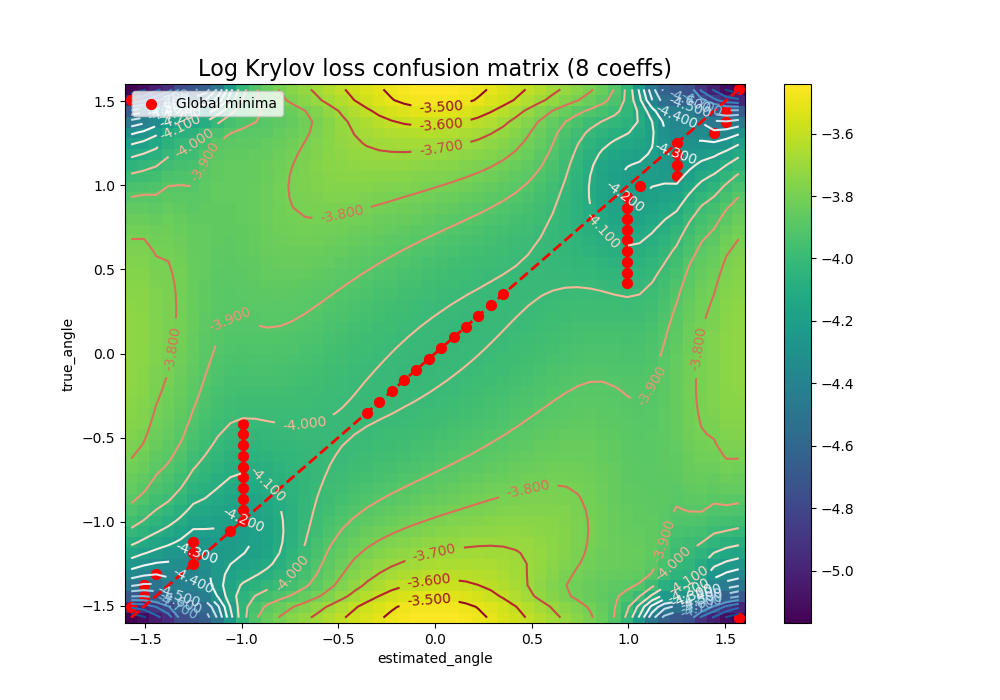

In [17]:
dataset = xr.load_dataset('confusion_matrix_diffusion_opening_angle_seed26626_degree8.nc')

%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(10,7))
np.log(dataset.loss / dataset.loss.sum('estimated_angle')).plot(ax=ax, add_labels=False)
cs = np.log(dataset.loss / dataset.loss.sum('estimated_angle')).plot.contour(ax=ax, cmap='RdBu_r', levels=20)
ax.clabel(cs, inline=1, fontsize=10)
ax.set_title('Log Krylov loss confusion matrix ({} coeffs)'.format(dataset.krylov_degree), fontsize=16)
ax.plot(dataset.true_angle, dataset.true_angle, 'r--', linewidth=2)

# plot minimas
min_idx = dataset.loss.argmin('estimated_angle')
minima = dataset.estimated_angle[min_idx]
ax.scatter(minima, dataset.true_angle, s=50, c='r', marker='o', label='Global minima')
plt.legend()

<IPython.core.display.Javascript object>


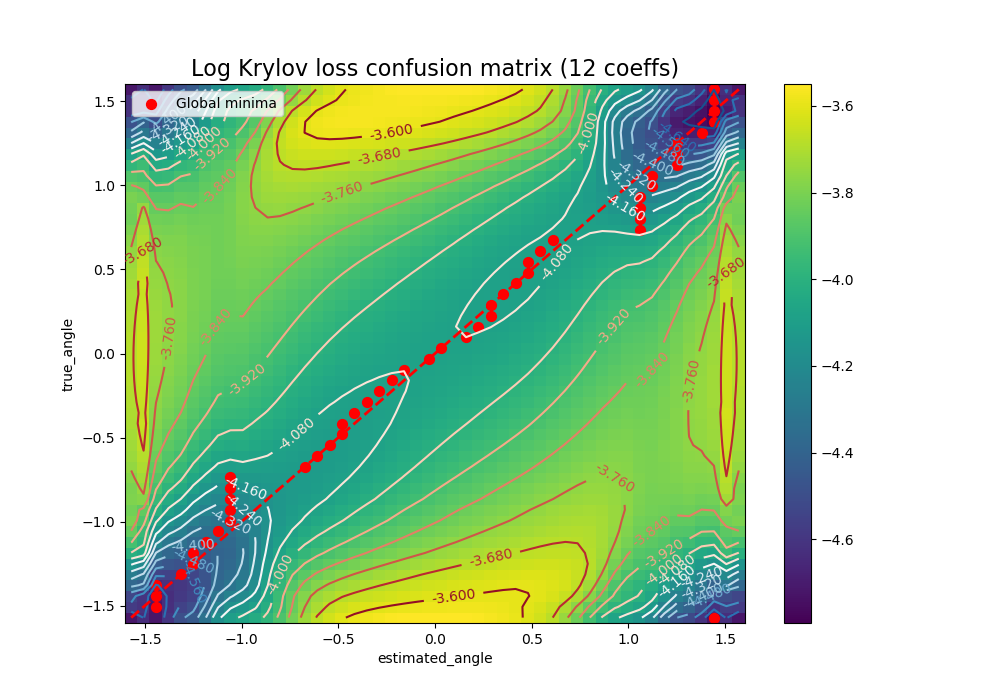

In [20]:
dataset = xr.load_dataset('confusion_matrix_diffusion_opening_angle_seed26626_degree12.nc')

%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(10,7))
np.log(dataset.loss / dataset.loss.sum('estimated_angle')).plot(ax=ax, add_labels=False)
cs = np.log(dataset.loss / dataset.loss.sum('estimated_angle')).plot.contour(ax=ax, cmap='RdBu_r', levels=20)
ax.clabel(cs, inline=1, fontsize=10)
ax.set_title('Log Krylov loss confusion matrix ({} coeffs)'.format(dataset.krylov_degree), fontsize=16)
ax.plot(dataset.true_angle, dataset.true_angle, 'r--', linewidth=2)

# plot minimas
min_idx = dataset.loss.argmin('estimated_angle')
minima = dataset.estimated_angle[min_idx]
ax.scatter(minima, dataset.true_angle, s=50, c='r', marker='o', label='Global minima')
plt.legend()